In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from sklearn.linear_model import LinearRegression

In [792]:
dfs = {}

train = datasets.MNIST('./data/mnist/train', train=True, download=True)
test = datasets.MNIST('./data/mnist/test', train=False, download=True)
dfs['MNIST'] = pd.DataFrame({
    'images': \
        [ image for image, label in train ] + [ image for image, label in test ],
    'labels': \
        [ label.item() for image, label in train ] + [ label.item() for image, label in test ],
})

train = datasets.CIFAR10('./data/mnist/train', train=True, download=True)
test = datasets.CIFAR10('./data/mnist/test', train=False, download=True)
dfs['CIFAR10'] = pd.DataFrame({
    'images': \
        [ image for image, label in train ] + [ image for image, label in test ],
    'labels': \
        [ label for image, label in train ] + [ label for image, label in test ],
})

# 50k random 1d pictures w/ 10px
dfs['RANDOM10'] = pd.DataFrame({
    'images': np.random.randn(50000, 10).tolist(),
    'labels': np.random.randint(2, size=50000)
})

# 50k random 1d pictures w/ 100px
dfs['RANDOM100'] = pd.DataFrame({
    'images': np.random.randn(50000, 100).tolist(),
    'labels': np.random.randint(2, size=50000)
})

train = datasets.ImageFolder('./data/tiny-imagenet-200/train')
test = datasets.ImageFolder('./data/tiny-imagenet-200/test')
dfs['TINYIMGNET'] = pd.DataFrame({
    'images': \
        [ image for image, label in train ] + [ image for image, label in test ],
    'labels': \
        [ label for image, label in train ] + [ label for image, label in test ],
})

Files already downloaded and verified
Files already downloaded and verified


In [793]:
NPS = 20
PMAX = np.inf
NSAMPLESMAX =40
PBREAK = 10000
nn_dists = {}

for name, df in dfs.items():
    if name == 'TINYIMGNET': continue
    print("DATASET:", name)

    Ps = [ int(i) for i in np.logspace(1, np.log10(len(df)), NPS) ]
    nn_dists[name] = {}

    for P in Ps:
        print(P, 10*'\t', end='\r')
        if P > len(dfs[name]):
            pass

        Pprime = min(P, NSAMPLESMAX) if P < PBREAK else NSAMPLESMAX*PBREAK//P
        dist_sum = 0

        x = torch.stack(list(
            dfs[name]['images'].sample(P).map(lambda x: torch.Tensor(np.asarray(x).reshape(-1,))).values
        ))
        d = x.shape[1]
        dists = (x.view(P,1,d).expand(P,Pprime,d) - \
            x[np.random.choice(range(P), Pprime, replace=False)].view(1,Pprime,d).expand(P,Pprime,d))\
            .pow(2).sum(dim=2)
        dists.apply_(lambda x: x if x > 0 else np.inf)
        nn_dists[name][P] = dists.min(dim=0)[0].mean().item()

DATASET: MNIST
DATASET: CIFAR10
DATASET: RANDOM10
DATASET: RANDOM100


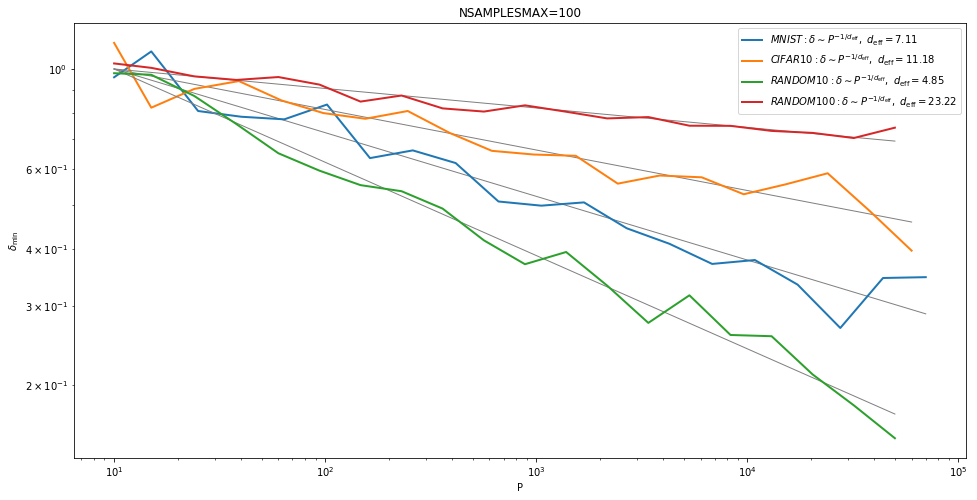

In [794]:
plt.figure(figsize=(16,8))

for name, dists in nn_dists.items():
#    if 'RANDOM' not in name: continue
    xs = np.asarray(list(dists.keys())).reshape(-1,1)
    ys = np.asarray(list(dists.values())).reshape(-1,)

    reg = LinearRegression().fit(np.log(xs), np.log(ys))
    ys0 = np.exp(reg.intercept_)*np.power(xs[0], reg.coef_) # just for normalization

    plt.plot(xs, [ np.exp(reg.intercept_)*np.power(x, reg.coef_)/ys0 for x in xs ], c='gray', lw=1)
    plt.plot(xs, ys/ys0, label="${}: \delta \sim P^{{-1/d_\mathrm{{eff}}}},\ d_\mathrm{{eff}}={:.2f}$".format(name, -1/reg.coef_[0]), lw=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('P')
plt.ylabel('$\delta_\mathrm{min}$')
plt.legend()
plt.title("NSAMPLESMAX=100")
plt.show()